In [105]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from util import prepare_df

In [88]:
df = prepare_df(
    "../outputs/20240214_180210_oracles_header.csv",
    "../outputs/20240214_180210_oracles_explo.csv",
)

In [89]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
task_palette = sns.color_palette("deep", int(df["n_task"].unique().shape[0]))
sns.set_theme(style="white", palette="deep", rc={"figure.figsize": (11.7, 8.27)})

In [90]:
df["Number of tasks"] = df["nbt"]
df["Schedulable"] = df["schedulable"]

In [91]:
df["oracle"] = df["safe"].combine_first(df["unsafe"])
df["oracle"] = df["oracle"].fillna("none")

In [92]:
df_root = df[
    ["tid", "n_task", "schedulable", "Number of tasks", "Schedulable"]
].drop_duplicates()
df_root = df_root.set_index("tid")

In [93]:
df_ss = df.pivot(index="tid", columns="oracle", values=["duration_s", "n_visited"])
df_ss.columns = list(map(lambda x: "_".join(x), df_ss.columns))
df_ss = df_root.join(df_ss)

In [94]:
oracle_sort_list = (
    df.groupby("oracle")["n_visited"].median().sort_values().index.to_list()[::-1]
)

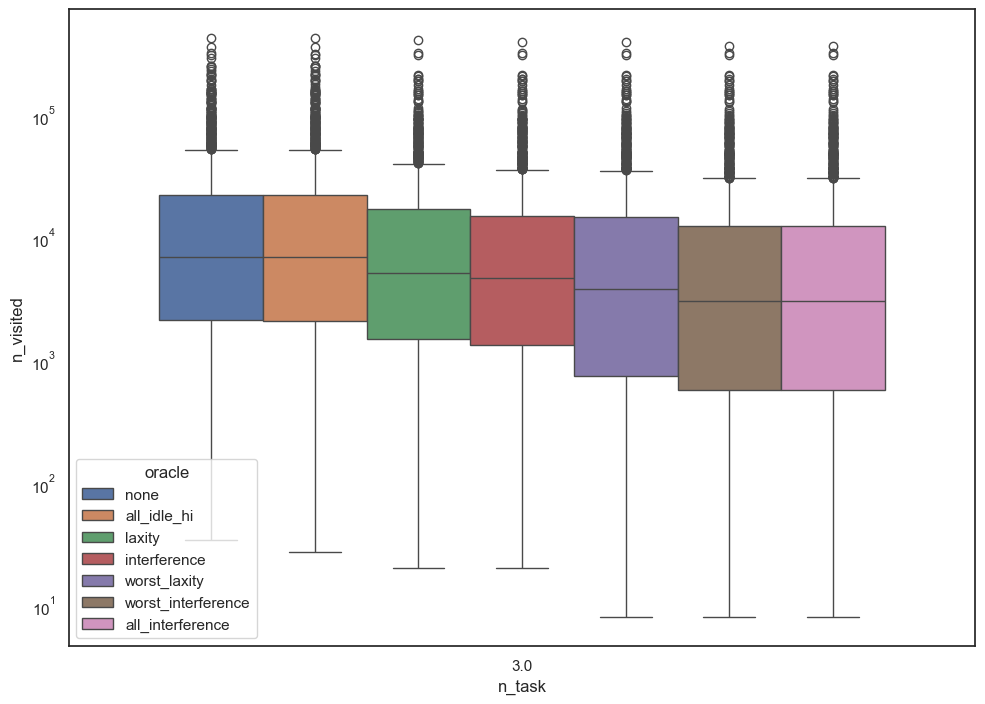

In [95]:
g = sns.boxplot(
    data=df,
    y="n_visited",
    x="n_task",
    hue="oracle",
    hue_order=df.groupby("oracle")["n_visited"]
    .median()
    .sort_values()
    .index.to_list()[::-1],
)
g.set_yscale("log")
plt.show()

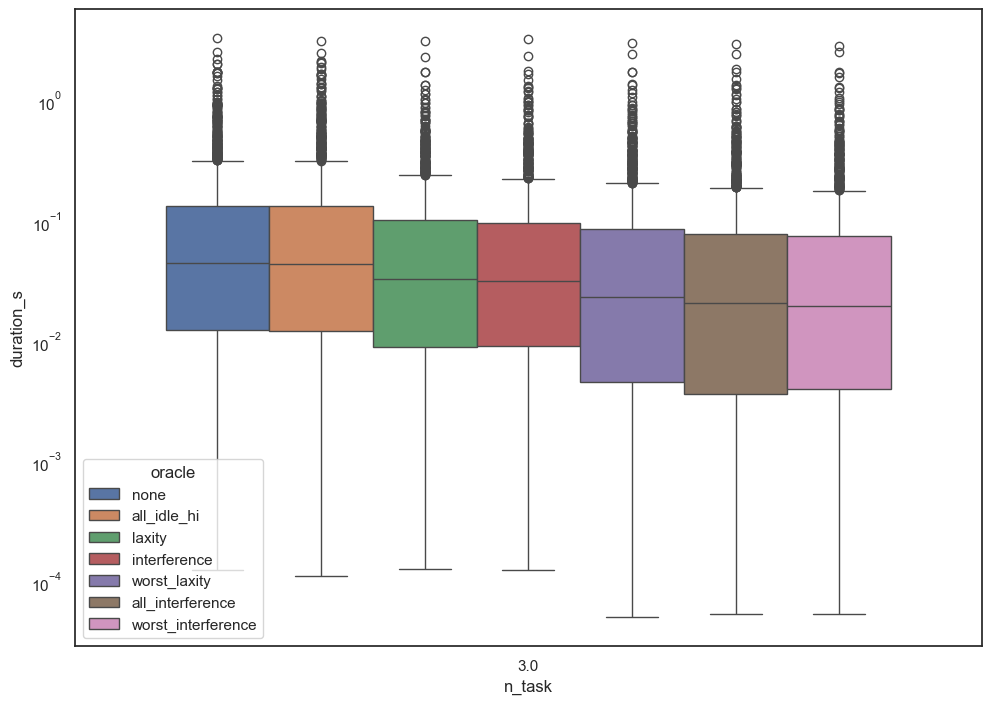

In [96]:
g = sns.boxplot(
    data=df,
    y="duration_s",
    x="n_task",
    hue="oracle",
    hue_order=df.groupby("oracle")["duration_s"]
    .median()
    .sort_values()
    .index.to_list()[::-1],
)
g.set_yscale("log")
plt.show()

In [97]:
df_comp = df.loc[df["oracle"] != "none"].merge(
    df.loc[df["oracle"] == "none", ["tid", "duration_s", "n_visited"]],
    on="tid",
    suffixes=("", "_none"),
)
df_comp["n_visited_ratio"] = df_comp["n_visited"] / df_comp["n_visited_none"]
df_comp["duration_s_ratio"] = df_comp["duration_s"] / df_comp["duration_s_none"]

In [98]:
df_sr = (
    1
    - df_comp.groupby(["oracle", "schedulable"])[
        ["duration_s_ratio", "n_visited_ratio"]
    ].median()
)
df_sr = df_sr.reset_index()
# df_sr["relative_duration_impact"] =1-df_sr["duration_s_ratio"]

In [101]:
df_sr_melt = df_sr.melt(
    id_vars=["oracle", "schedulable"],
    value_vars=["duration_s_ratio", "n_visited_ratio"],
)

df_sr_melt = df_sr_melt.rename(
    columns={
        "variable": "Metric",
        "value": "Compression",
        "schedulable": "Schedulable",
        "oracle": "Oracle",
    }
)

metric_map = {
    "duration_s_ratio": "Execution time (s)",
    "n_visited_ratio": "Numder of visited states before halt",
}

df_sr_melt["Metric"] = df_sr_melt["Metric"].map(lambda x: metric_map[x])

oracle_map = {
    "all_idle_hi": "All idle HI",
    "all_interference": "All interference",
    "interference": "Interference",
    "none": "None",
    "laxity": "Laxity",
    "worst_interference": "HI-Interference",
    "worst_laxity": "Worst Laxity",
}

df_sr_melt["Oracle"] = df_sr_melt["Oracle"].map(lambda x: oracle_map[x])

,Oracle,Schedulable,Metric,Compression
0,All idle HI,False,Execution time (s),0.010405
1,All idle HI,True,Execution time (s),0.028254
2,All interference,False,Execution time (s),0.922726
3,All interference,True,Execution time (s),-0.077101
4,Interference,False,Execution time (s),0.558435
5,Interference,True,Execution time (s),-0.044936
6,Laxity,False,Execution time (s),0.460883
7,Laxity,True,Execution time (s),-0.000779
8,HI-Interference,False,Execution time (s),0.921947
9,HI-Interference,True,Execution time (s),-0.025182


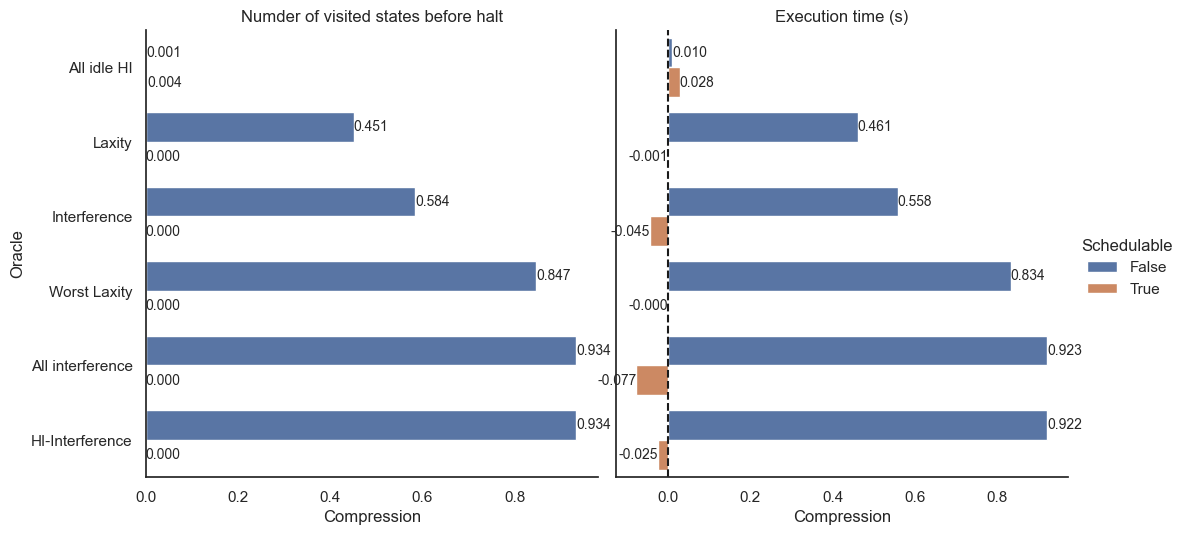

In [106]:
fg = sns.catplot(
    df_sr_melt,
    kind="bar",
    x="Compression",
    y="Oracle",
    col="Metric",
    hue="Schedulable",
    height=5.5129,
    aspect=1,
    sharex=False,
    order=df_sr_melt.groupby("Oracle")["Compression"].max().sort_values().index,
    col_order=["Numder of visited states before halt", "Execution time (s)"],
)


fg.set_titles("{col_name}")

# draw a dashed vertical line at 0 on the first plot of the face grid
fg.axes[0, 1].axvline(0, color="k", linestyle="--")


fg.axes[0, 0].bar_label(fg.axes[0, 0].containers[0], fontsize=10, fmt="%.3f")
fg.axes[0, 0].bar_label(fg.axes[0, 0].containers[1], fontsize=10, fmt="%.3f")
fg.axes[0, 1].bar_label(fg.axes[0, 1].containers[0], fontsize=10, fmt="%.3f")
fg.axes[0, 1].bar_label(fg.axes[0, 1].containers[1], fontsize=10, fmt="%.3f")

fg.savefig(f"{datetime.now().strftime('%Y%m%d%H%M%S')}_oracle.pdf", bbox_inches="tight")

In [103]:
df_comp.groupby("oracle")["n_visited_ratio"].mean()

oracle
all_idle_hi           0.991843
all_interference      0.730839
interference          0.813401
laxity                0.840787
worst_interference    0.730839
worst_laxity          0.769276
Name: n_visited_ratio, dtype: float64

(-0.14518629715628187,
 4.387032771762283,
 -0.00658507995378145,
 1.0895729406604995)

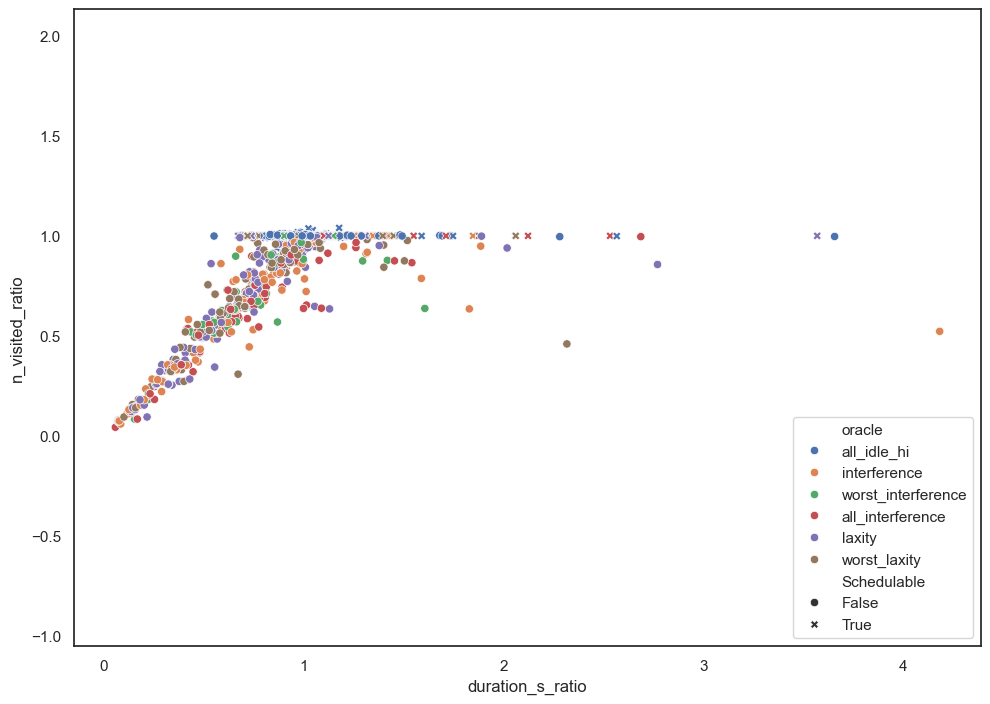

In [114]:
f3, ax3 = plt.subplots()

scope = df_comp["duration_s"] > 0.1

df_plot = df_comp.loc[scope]

sns.scatterplot(
    data=df_plot,
    x="duration_s_ratio",
    y="n_visited_ratio",
    style="Schedulable",
    hue="oracle",
    ax=ax3,
)
ax3.axis("equal")